# DEEE725 Speech Signal Processing Lab
### 2023 Spring, Kyungpook National University 
### Instructor: Gil-Jin Jang

## Lab 04 Spectral subtraction, Wiener filtering, end point detectoin, voice activity detection
2023/04/07

----
### import packages, define analysis parameters and draw parameters, etc.

In [1]:
# import necessary pacakages
# strange issue: keep the import order to prevent matplotlib error
#  import matplotlib -> librosa -> pyplot -> librosa.display
import sys
import numpy as np
import matplotlib
import librosa
from matplotlib import pyplot as plt
import librosa.display

#from scipy.io import wavfile
from scipy import signal
from scipy.fft import fftshift

신호 분석과 스펙트럼을 그리기 위한 다음의 parameter 들을 정의한다.
입력 파일의 sampling frequency 를 이용하여 shift size 를 sample 수로 정의하기 위해 사용된다.
- `Ts`: shift length in seconds, default 0.01 sec = 10 ms. 
- `Tf`: frame length in seconds, default 0.02 sec = 20 ms

In [2]:
# parameters for signal analysis
# Fs = 16000  native sampling frequency (wav file 에 정의된 것) 을 사용하면 필요 없음
Ts = 0.01   # 10 ms shift size
Tf = 0.02   # 20 ms frame size

spectrum 을 그리기 위한 parameters.
- `cmap_plot`: colormap. default value is `pyplot.cm.bone_r` (최소값 흰색, 최대값 검은색 의 gray scale) 

In [3]:
# parameters for drawing
#cmap_plot = plt.cm.bone # default colormap for spectrogram, gray
cmap_plot = plt.cm.bone_r # default colormap for spectrogram, gray, reversed
#cmap_plot = plt.cm.plasma 
#cmap_plot = plt.cm.inferno
#FIG_SIZE = (15,10)   # obsolete
FIG_SIZE = (8,3)

---
### 이전 lab 들에서 정의한 함수들

In [4]:
# returns decibel, with preventing 0 input
# note: input should be X(w) or x[n]
# dB = 20 log_10 (abs(x)) = 10 log_10 ( x^2 ) 
def decibel_sq_safe(x, epsilon=1e-10):
    return 10*np.log10(np.maximum(np.real(x*np.conj(x)),epsilon))

def drawspectrogram2(x, Nf, Ns=None, winname='hamming', minpercentile=80, isdbscale=True, isdraw=True):
    # Short-time Fourier transform with half-overlap 
    # Nf: analysis size
    # Ns: shift size 
    # NFFT: FFT size, power of 2
    if Ns==None: Ns=Nf//2
    num_frames = (len(x)-Nf)//Ns+1  # 마지막 채워지지 않은 프레임은 버린다. 구현에 따라 zero-padding해서 사용 가능
    NFFT = int(2**(np.ceil(np.log2(Nf))))   # Nf보다 크거나 같은 2의 거듭제곱을 NFFT 로 정의
    hNo = NFFT//2+1
    X = np.zeros((hNo,num_frames))
    
    # generate window
    if winname=='rect' or winname=='rectangular':
        win = np.ones(Nf)
    else:   # hamming, hann, etc.
        win = librosa.filters.get_window(winname, Nf, fftbins=True)
        
    # STFT
    for i in range(num_frames):
        y = np.fft.fft(win*x[(i*Ns):(i*Ns+Nf)], n=NFFT)
        y = y[:hNo]
        if isdbscale: y = decibel_sq_safe(y)
        else: y = np.abs(y)
        X[:,i] = y

    if isdraw:
        # 상위 80% 정도만 scale 한다. imshow의 vmin vmax 이용 
        vmax = np.max(X[:])
        vmin = np.percentile(X[:], minpercentile)
        specgram_axis = [0,float(len(x))/float(Fs),0,float(Fs)/2]
        plt.imshow(X, cmap=cmap_plot, aspect='auto', origin='lower', extent=specgram_axis, vmax=vmax, vmin=vmin)
        plt.xlabel('time (seconds)')
        plt.ylabel('frequency (Hz)')
    
    return X

---
### load speech and noise

Speech 와 noise 파일을 정의한다.

In [5]:
speechfile = 'gjang-kdigits0-3.wav'
noisefile  = 'car.wav'

__load an example windows wav file__
- `librosa.load()`는 $-1 \sim 1$
- 읽어들인 sampling frequency $F_s$ 를 이용하여 frame size $N_f$, shift size $N_s$를 계산한다.
- FFT (fast Fourier transform) 크기는 $N_f$ 보다 크거나 같은 2의 거듭제곱으로 FFT 크기 $N_{FFT}$ 을 정의함
$$ N_{FFT} = 2^{\lceil \log_{2} N_{f} \rceil} $$

In [6]:
# load audio files with Librosa
speech, Fs = librosa.load(speechfile, sr=None, mono='True')
noise, _ = librosa.load(noisefile, sr=Fs, mono='True')
# sr: target sampling rate. ‘None’ uses the native sampling rate
# mono = True: convert signal to mono

print(speech,speech.shape)
print(noise,noise.shape)

Ns = int(Fs*Ts)    # shift number of samples
Nf = int(Fs*Tf)    # frame number of samples
NFFT = int(2**(np.ceil(np.log2(Nf))))   # Nf보다 크거나 같은 2의 거듭제곱을 NFFT 로 정의
hNo = NFFT//2+1
print('Fs = %d, Ns = %d, Nf = %d, NFFT = %d, hNo = %d' % (Fs, Ns, Nf, NFFT, hNo))

[-4.7912598e-03 -3.7231445e-03 -3.3569336e-03 ... -3.0517578e-05
 -8.8500977e-04  8.5449219e-04] (37952,)
[-0.01342773 -0.0222168  -0.02905273 ... -0.0390625  -0.03930664
 -0.04086304] (175745,)
Fs = 16000, Ns = 160, Nf = 320, NFFT = 512, hNo = 257


__generate noisy speech with various SNRs__

In [7]:
mixsnrs = np.array([20, 10, 0, -10])
std_s = np.std(speech)
std_n = np.std(noise)
mixedSig = []
for snr in mixsnrs:
    gain = np.power(10, -snr/20)
    print('SNR = %.0f dB, gain = %.2f' % (snr, gain))
    m = speech + noise[:len(speech)]/std_n*std_s*gain
    mixedSig.append(m)

SNR = 20 dB, gain = 0.10
SNR = 10 dB, gain = 0.32
SNR = 0 dB, gain = 1.00
SNR = -10 dB, gain = 3.16


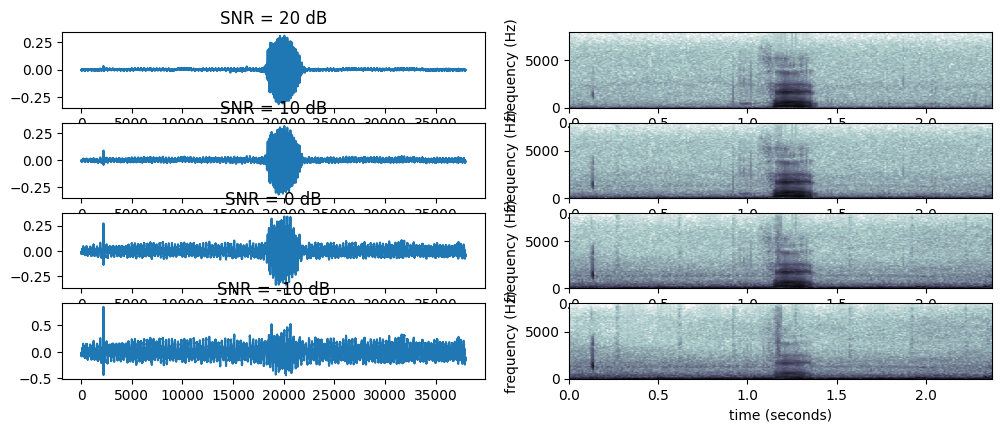

In [8]:
plt.figure(figsize=FIG_SIZE*np.array([1.5,1.5]))

for m in range(len(mixedSig)):
    plt.subplot(len(mixedSig),2,(m+1)*2-1)
    plt.plot(mixedSig[m])
    plt.title('SNR = %.0f dB' % (mixsnrs[m]))
    plt.subplot(len(mixedSig),2,(m+1)*2)
    drawspectrogram2(mixedSig[m], Nf, Ns, minpercentile=1, isdbscale=True, isdraw=True)

Noise spectrum estimation
1. noise 는 stationary, speech 는 non-stationary 가정
2. 처음 0.5~1초는 noise 만 있다고 가정하고 이 구간의 평균 spectral energy ($|\cdot|^2$) 을 추정

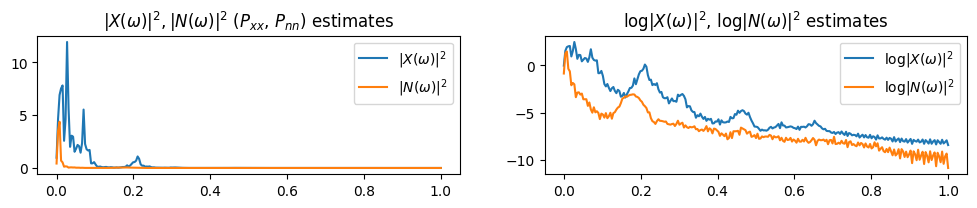

In [9]:
####################################
# 10 dB mixed speech 스펙트럼
mix = mixedSig[1]
Nx = len(mix)
nframes = int((Nx-Nf)//Ns+1)
Pxx = np.zeros(hNo)   # E[X*conj(X)]
for n in range(nframes):
    x = mix[(n*Ns):(n*Ns+Nf)]
    X = np.fft.fft(x, NFFT)
    aX2 = (X*np.conj(X))
    Pxx += aX2[:hNo].real
    
# average (E[x*conj(x)]
Pxx /= nframes

####################################
# 0-0.5초에 대하여 잡음 스펙트럼 추정
mix = mixedSig[1]
Tn = 0.5   # 0~0.5초
Nn = Tn*Fs
nframes = int((Nn-Nf)//Ns+1)
Pnn = np.zeros(hNo)   # E[N*conj(N)]
for n in range(nframes):
    x = mix[(n*Ns):(n*Ns+Nf)]
    X = np.fft.fft(x, NFFT)
    aX2 = (X*np.conj(X))
    Pnn += aX2[:hNo].real
    
# average (expected value)
Pnn = Pnn/nframes

####################################
# plot
plt.figure(figsize=FIG_SIZE*np.array([1.5,0.6]))
xticks=np.linspace(0, 1, num=hNo, endpoint=True)

plt.subplot(1,2,1)
plt.plot(xticks,Pxx,label='$|X(\omega)|^2$')
plt.plot(xticks,Pnn,label='$|N(\omega)|^2$')
plt.title('$|X(\omega)|^2, |N(\omega)|^2$ ($P_{xx}$, $P_{nn}$) estimates')
plt.legend(loc='upper right')
plt.subplot(1,2,2)
plt.plot(xticks,np.log(Pxx),label='$\log |X(\omega)|^2$')
plt.plot(xticks,np.log(Pnn),label='$\log |N(\omega)|^2$')
plt.title('$\log |X(\omega)|^2$, $\log |N(\omega)|^2$ estimates')
plt.legend(loc='upper right')

In [10]:
####################################
def __sumSpect(x, I):
    #plt.figure(figsize=FIG_SIZE*np.array([1.5,0.9]))
    #plt.plot(x[I[0]:I[1]])
    Nt = I[1]-I[0]
    nframes = int((Nt-Nf)//Ns+1)
    Pxx = np.zeros(hNo)   # E[N*conj(N)]
    for n in range(nframes):
        X = np.fft.fft(x[(n*Ns+I[0]):(n*Ns+Nf+I[0])], NFFT)
        aX2 = (X*np.conj(X))
        Pxx += aX2[:hNo].real
        
    return Pxx, nframes

####################################
def estSpect(x, IntervalMulti=[]):
    # x: 1-dim time domain signal
    # IntervalMulti:  
    #   2-dim matrix, [n_interval, 2]: multiple intervals
    #   empty list: use all x
    if len(IntervalMulti) == 0:
        IntervalMulti = np.array([[0, len(x)]])
    print(IntervalMulti, IntervalMulti.shape)
    
    # accumulate interval power spectral densities
    PxxSum = np.zeros(hNo)   # E[N*conj(N)]
    NumFrames = 0
    for ii in range(IntervalMulti.shape[0]):
        [Pxx, N] = __sumSpect(x, IntervalMulti[ii,:].astype(int))
        PxxSum = PxxSum + Pxx
        NumFrames += N
        
    # average (E[x*conj(x)]
    return PxxSum/NumFrames

[[    0 37952]] (1, 2)
[[17600. 22400.]] (1, 2)
[[   0. 8000.]] (1, 2)
[[    0. 16000.]
 [24000. 32000.]
 [32000. 35200.]] (3, 2)


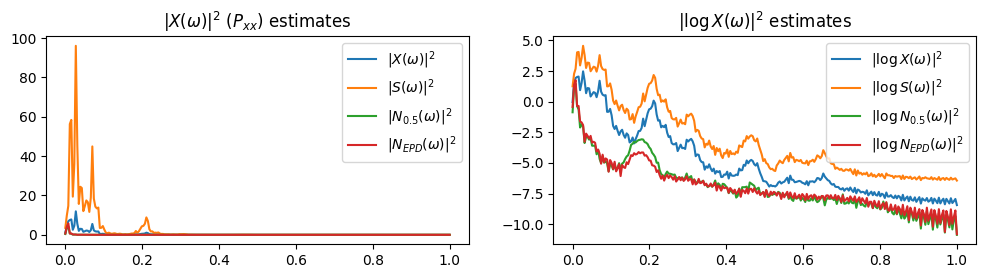

In [11]:
####################################
mix = mixedSig[1]
PxxAll = estSpect(mix, [])
PxxEPD = estSpect(mix, np.array([[1.1, 1.4]])*Fs)
PnnHead = estSpect(mix, np.array([[0.0, 0.5]])*Fs)
PnnEPD = estSpect(mix, np.array([[0,1.0], [1.5, 2.0], [2.0, 2.2]])*Fs)

####################################
# plot
plt.figure(figsize=FIG_SIZE*np.array([1.5,0.9]))
xticks=np.linspace(0, 1, num=hNo, endpoint=True)

plt.subplot(1,2,1)
plt.plot(xticks,PxxAll,label='$|X(\omega)|^2$')
plt.plot(xticks,PxxEPD,label='$|S(\omega)|^2$')
plt.plot(xticks,PnnHead,label='$|N_{0.5}(\omega)|^2$')
plt.plot(xticks,PnnEPD,label='$|N_{EPD}(\omega)|^2$')
plt.title('$|X(\omega)|^2$ ($P_{xx}$) estimates')
plt.legend(loc='upper right')
plt.subplot(1,2,2)
plt.plot(xticks,np.log(PxxAll),label='$|\log X(\omega)|^2$')
plt.plot(xticks,np.log(PxxEPD),label='$|\log S(\omega)|^2$')
plt.plot(xticks,np.log(PnnHead),label='$|\log N_{0.5}(\omega)|^2$')
plt.plot(xticks,np.log(PnnEPD),label='$|\log N_{EPD}(\omega)|^2$')
plt.title('$|\log X(\omega)|^2$ estimates')
plt.legend(loc='upper right')

In [24]:
######################################################################
# class definition for trapezoidal FIR filter overlap-add

'''
# usage example
# create an instance of class firoverlapadd
# shift 10ms, overlap 3ms
fola = firoverlapadd()
fola.setbyLPHFIRtab(len(h_a[0]), int(Fs*0.010), int(Fs*0.003))
y = fola.doFilterAll(h_a, sinusoid)
# y is the online output stream (with delay 3ms)
'''

#######################################################
# re-definition of getFIRFFT to
# 1. make sure that it generates linear phase (symmetric real) filter
# 2. be renamed to indiate the above
# 3. return the linear phase filter and the delay incurred by the filtering
def getLPHFIRFFT(H, order, winname=None):
    # H: NFFT/2+1
    NFFT = (len(H)-1)*2
    H = np.concatenate((H, H[-2:0:-1])) + np.zeros(NFFT)*(1j)
    h = np.fft.ifft(H, NFFT)

    # adjust order if necessary
    order = min(NFFT-1, order)  # at most NFFT samples
    delay = order//2     # delay by the filtering is half the order
    order = delay*2      # odd order -> even so that the filter is symmetric w.r.t. the center sample

    #h = np.concatenate((h[len(h)//2:], h[0:len(h)//2]))
    h = np.concatenate((h[(len(h)-delay):], h[0:delay+1]))
    if winname != None:
        win = librosa.filters.get_window(winname, order+1, fftbins=False)
        h = h*win
    return h.real, delay

class firoverlapadd:
    def __init__(self):
        self.initializeAllVar()

    def initializeAllVar(self):
        # initially, all empty
        self.Ns = 0
        self.Nov = 0
        self.M = 0
        self.FIRshift = 0
        self.rwin = np.zeros(0)
        self.lwin = np.zeros(0)
        self.lastNx = 0   # length of last x input
        self.lastNy = 0   # length of last y output
        self.xbuf = np.zeros(0)
        self.ybuf = np.zeros(0)
        self.yout = np.zeros(0)

    # set the parameters using number of samples
    # Ns, Nov: do not change when the given values are less than or equal to 0
    # order, FIRshift: do not change when the given values are less than 0 (0 is valid)
    def set(self, Ns=0, Nov=0, order=-1, FIRshift=-1):
        if Ns>0: self.Ns = Ns
        if Nov>0: self.Nov = Nov
        if order>=0: self.M = order
        if FIRshift>=0: self.FIRshift = FIRshift
        self.allocBuffer()

    # find order and FIRshift from the linear phase filter
    def setbyLPHFIRtab(self, ntab, Ns=0, Nov=0):
        self.set(Ns, Nov, self.getOrderByFilter(ntab), self.getLinearPhaseDelay(ntab))

    # set the order by an FIR filter
    def getOrderByFilter(self, ntab): 
        return ntab-1
    # set the FIR shift by a linear phase FIR filter
    def getLinearPhaseDelay(self, ntab):
        return (ntab-1)//2
    # delay of the output
    def getDelay(self): 
        return self.Nov+self.FIRshift
        #return self.Nov

    # allocate memory and buffers, assuming that the numbers are already set properly
    def allocBuffer(self):
        self.rwin = np.linspace(1,0,self.Nov+2)[1:-1]
        self.lwin = np.linspace(0,1,self.Nov+2)[1:-1]
        self.xbuf = np.zeros(self.M+self.Nov+self.Ns)
        self.ybuf = np.zeros(self.M+self.Nov+self.Ns)
        self.yout = np.zeros(self.Ns)
        self.lastNx = 0
        self.lastNy = self.getDelay()

    # clear all the memory and buffers
    def resetBuffer(self):
        self.xbuf[:] = 0
        self.ybuf[:] = 0
        self.yout[:] = 0
        self.lastNx = 0
        self.lastNy = self.getDelay()

    # single frame processing
    def doFilterMem(self, h, x):
        ############################################
        # elaborate input x
        # x-1. shift buffer
        for ii in range(self.M+self.Nov):
            self.xbuf[ii] = self.xbuf[ii+self.Ns]
            
        # x-2. copy the new input
        self.lastNx = len(x)
        if len(x) > 0:
            for ii in range(len(x)):
                self.xbuf[ii+self.M+self.Nov] = x[ii]
            for ii in range(len(x),self.Ns):
                self.xbuf[ii+self.M+self.Nov] = 0
        else:   # no input, clear buffer
            self.xbuf[(self.M+self.Nov):] = np.zeros(self.Ns)

        ############################################
        # generate output y
        # y-1. copy the overlapped old output, overlapped
        self.yout[:self.Nov] = self.ybuf[(-self.Nov):]
        
        # y-2. do filtering (if necessary)
        if len(h) > 1: 
            # if do assignment as follows, exception unless 
            # the lengths of left and right match (to prevent bug)
            self.ybuf[:] = signal.lfilter(h, [1], self.xbuf)
        elif len(h) == 1:  # simple amplifier
            self.ybuf[:] = h[0]*self.xbuf[:]
        else:   # no filter at all
            self.ybuf[:] = np.zeros(self.M+self.Nov+self.Ns)
        
        # y-3. multiply trapezoidal window
        self.ybuf[self.M:(self.M+self.Nov)] *= self.lwin
        self.ybuf[(-self.Nov):] *= self.rwin
        
        # y-4. overlap-add
        self.yout[:self.Nov] += self.ybuf[self.M:(self.M+self.Nov)]
        self.yout[self.Nov:self.Ns] = self.ybuf[(self.M+self.Nov):(self.M+self.Ns)]

        '''
        plt.figure(figsize=FIG_SIZE*np.array([1.8,0.5]))
        plt.subplot(2,1,1)
        plt.plot(self.ybuf[self.M:])
        plt.subplot(2,1,2)
        plt.plot(self.yout)
        '''
        
        # y-5. update output buffer length
        self.lastNy = self.lastNy + self.lastNx
        len_out = min(self.lastNy, self.Ns)
        #print('lastNx = %d, lastNy = %d, Ns = %d, len_out = %d' % (self.lastNx, self.lastNy, self.Ns, len_out))
        self.lastNy -= len_out

        # output and actual length
        return self.yout, len_out
    
    # all audio signal processing
    def doFilterAll(self, H, X):
        y = np.zeros(0)   # start from empty signal
        Ly, Lx, n = 0, len(X), 0
        while True:
            # 1. input
            t1,t2 = min(Lx,n*self.Ns),min(Lx,(n+1)*self.Ns)
            x = X[t1:t2]

            # 2. filtering with memory and overlap add
            if n >= len(H): h = []
            else: h = H[n]
            [yt,Lyt] = self.doFilterMem(h, x)

            # 3. process one frame and append it
            if Lyt > 0:
                Ly += Lyt
                y = np.concatenate((y, yt[:Lyt]))
            else: break
            n+=1
        return y

[[   0. 8000.]] (1, 2)
[[   0. 8000.]] (1, 2)


/tmp/ipykernel_371220/3222998019.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


[[   0. 8000.]] (1, 2)
[[   0. 8000.]] (1, 2)


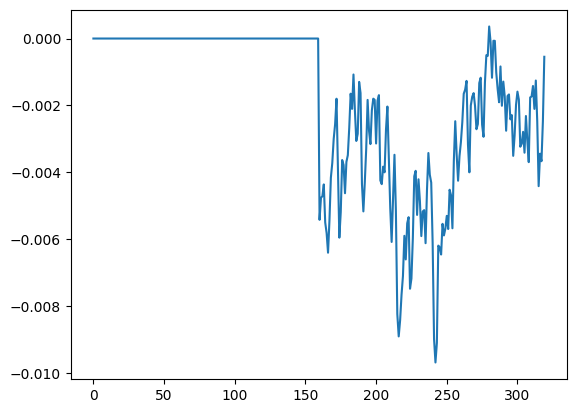

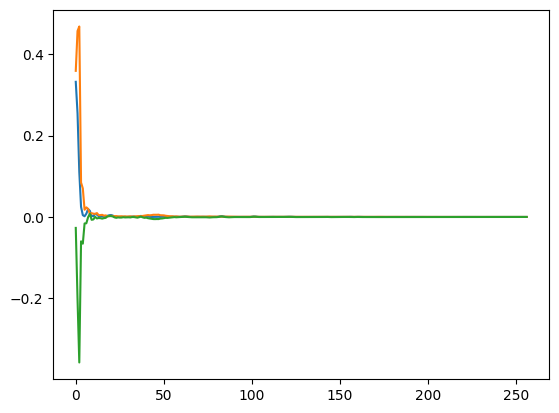

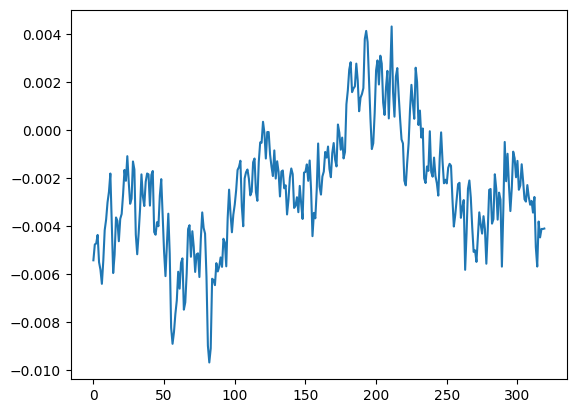

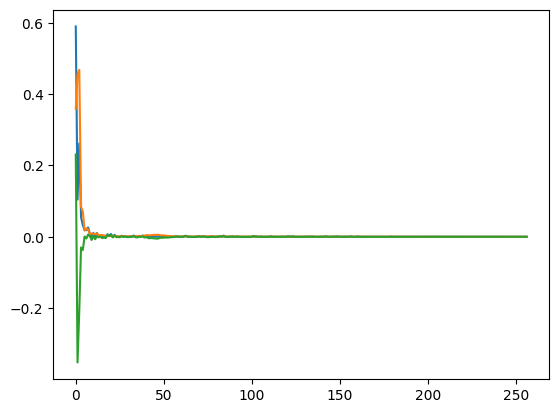

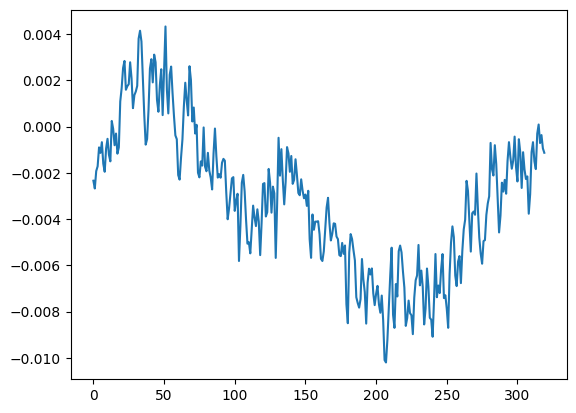

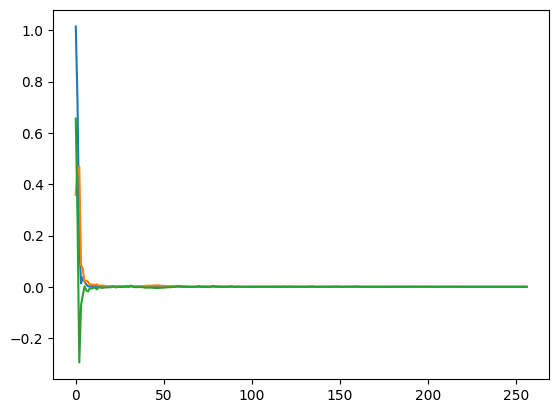

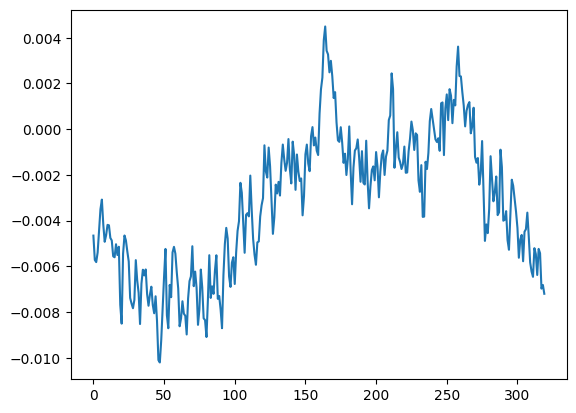

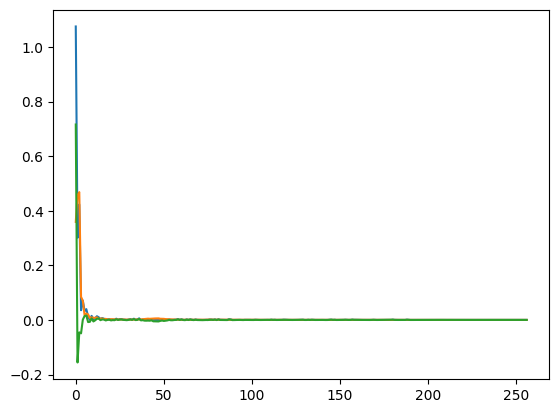

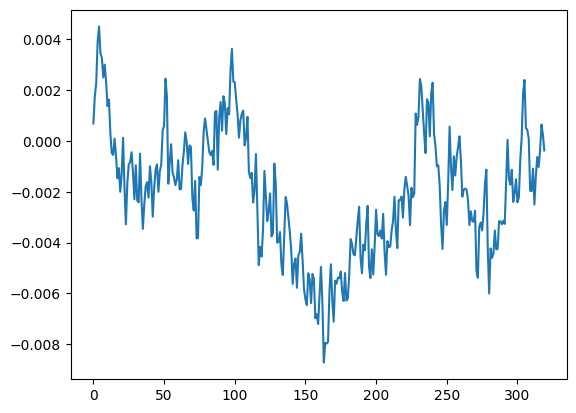

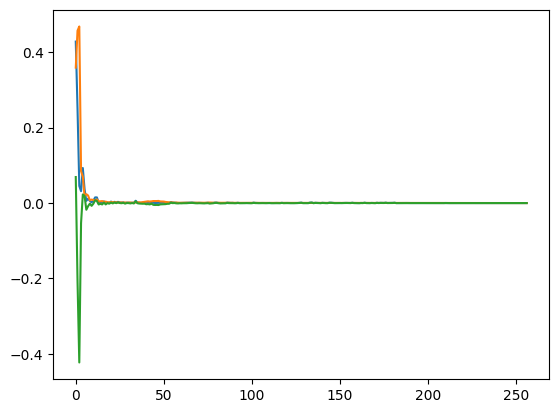

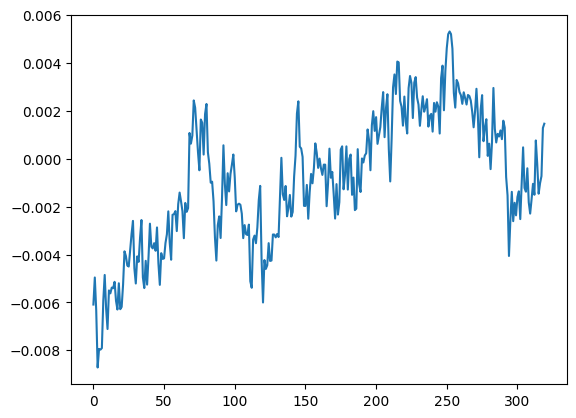

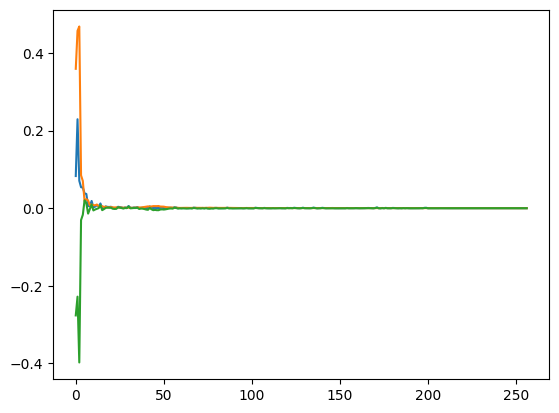

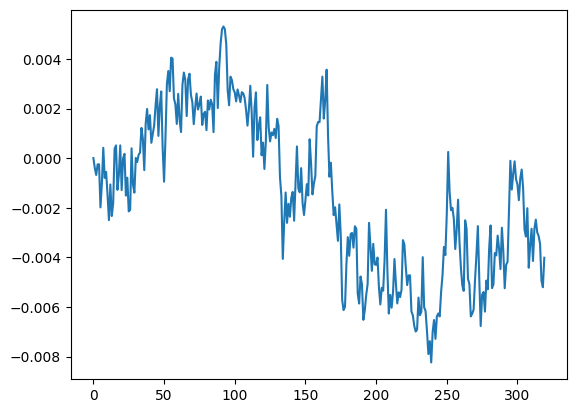

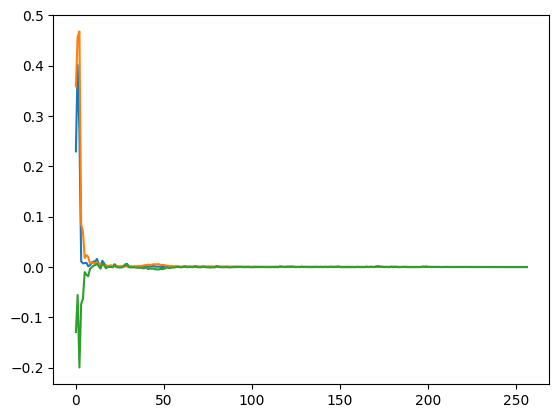

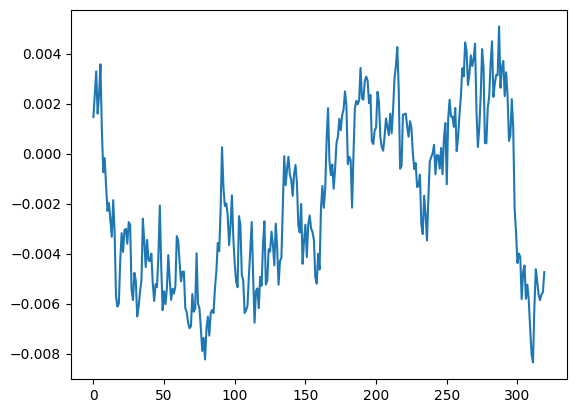

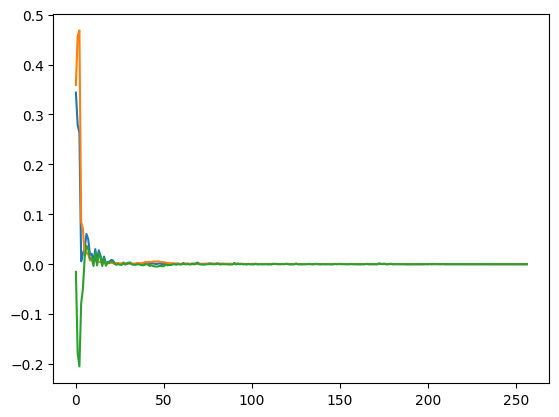

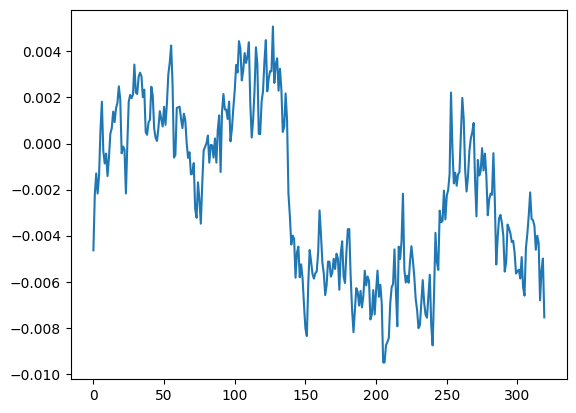

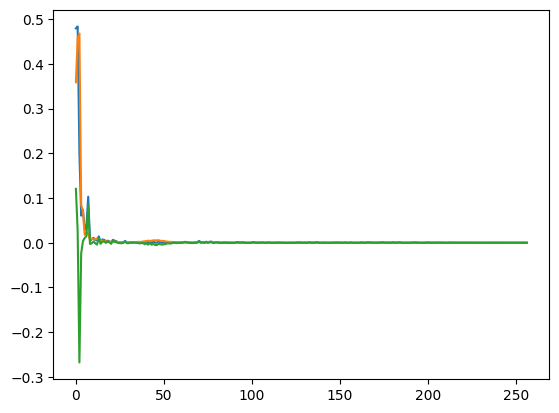

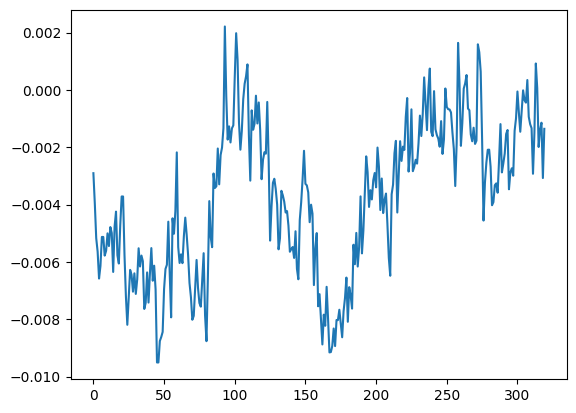

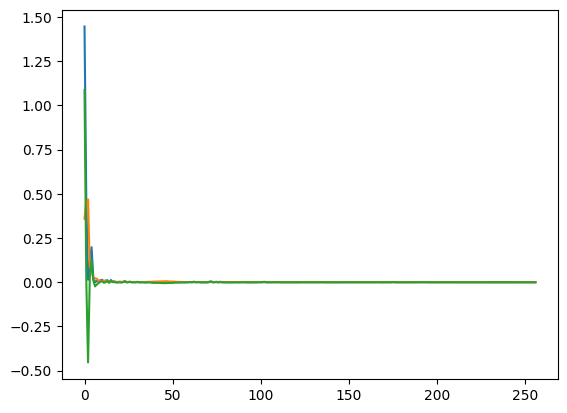

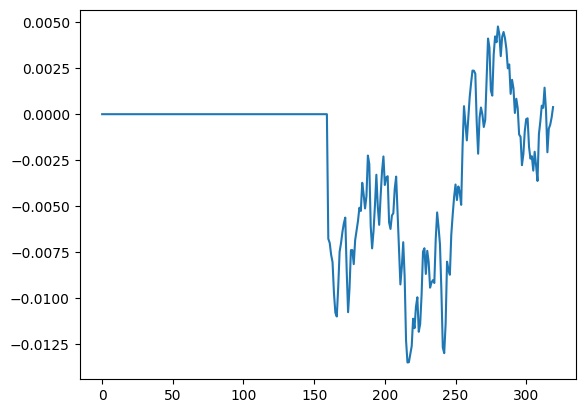

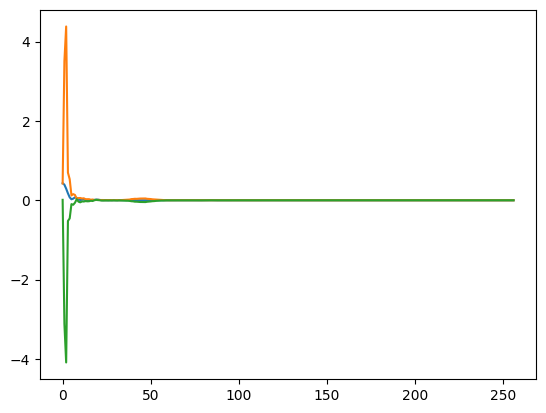

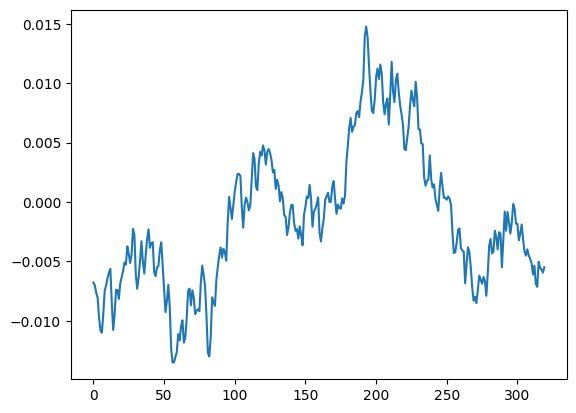

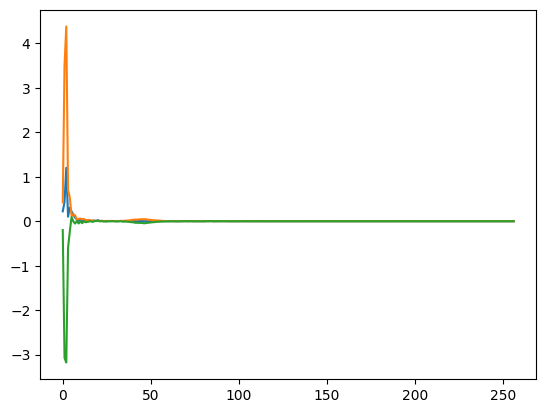

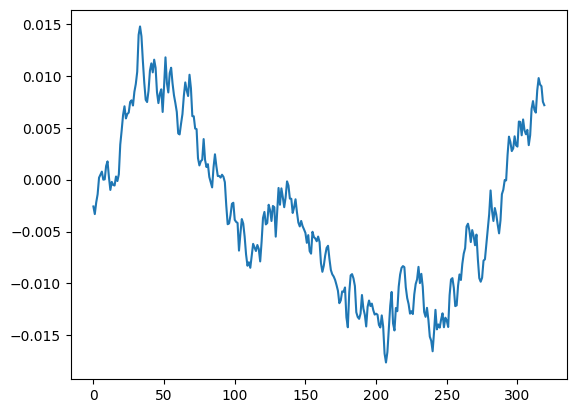

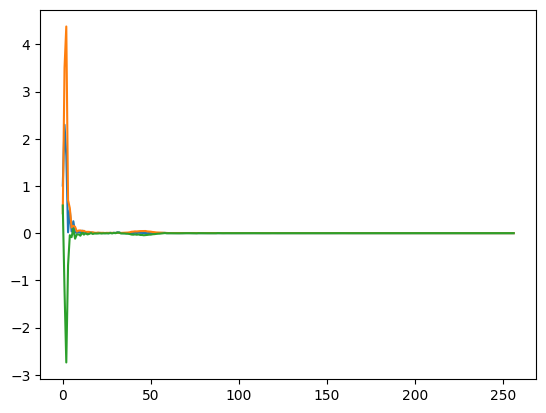

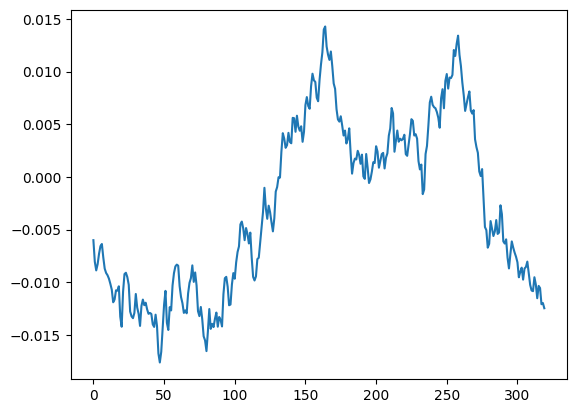

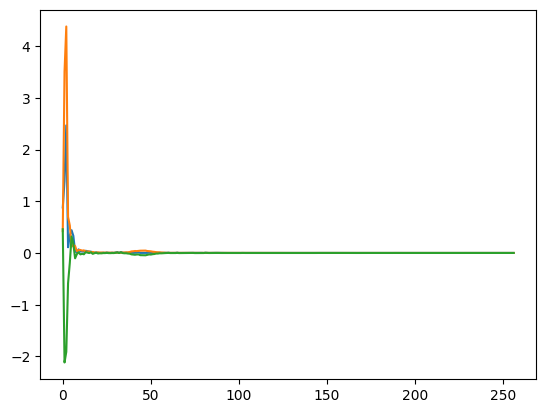

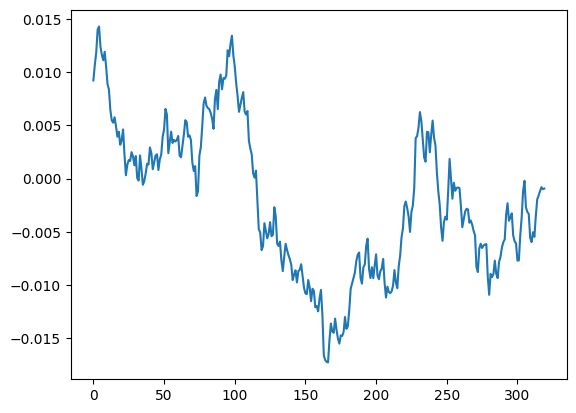

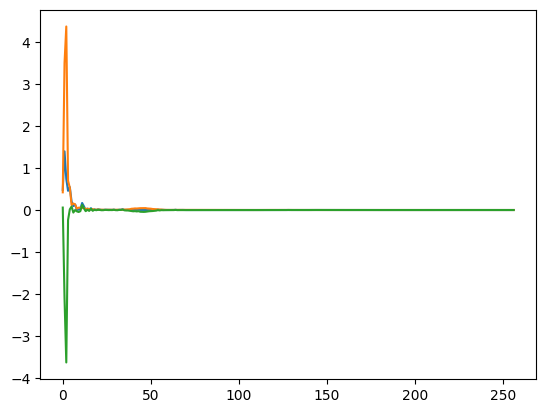

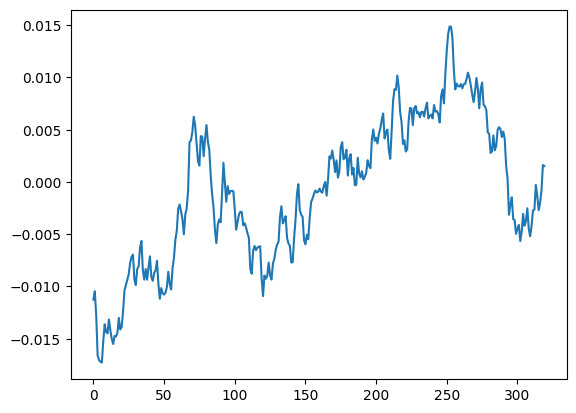

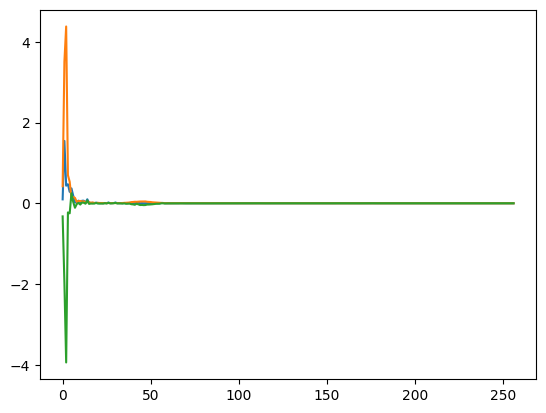

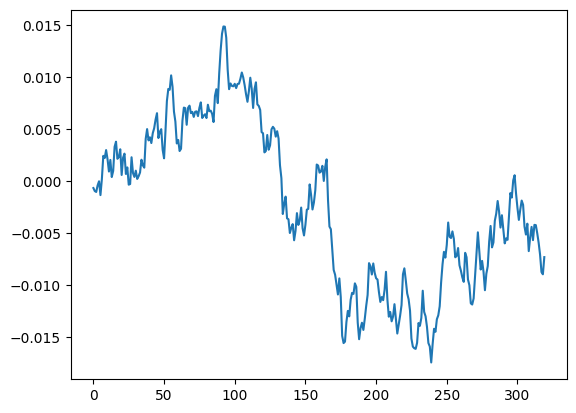

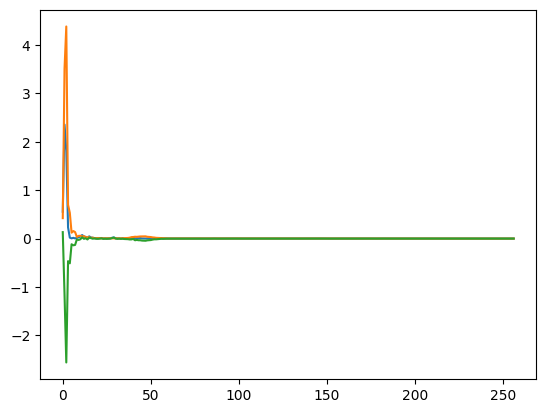

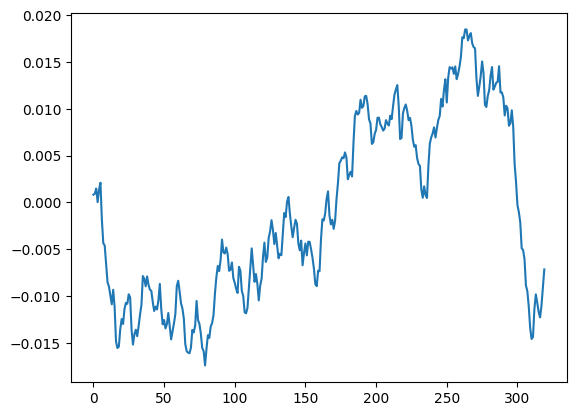

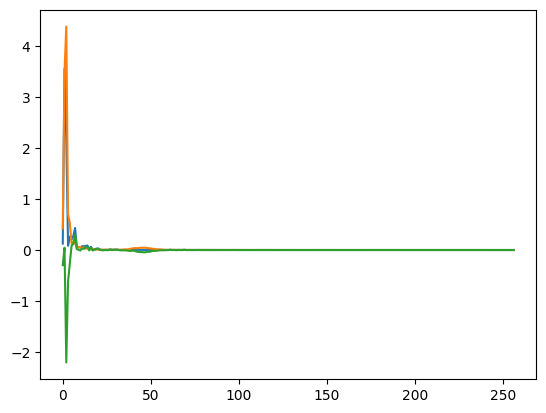

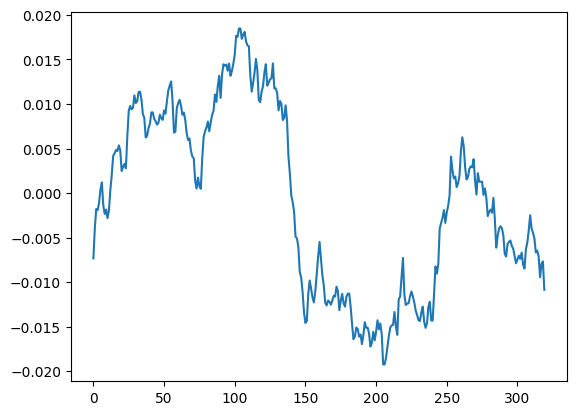

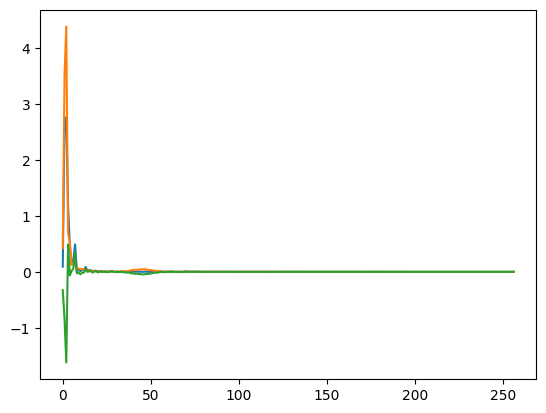

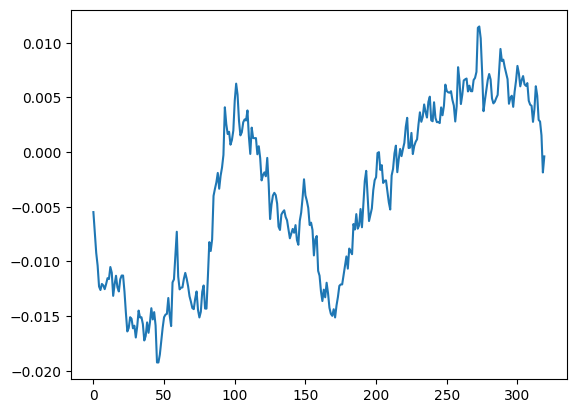

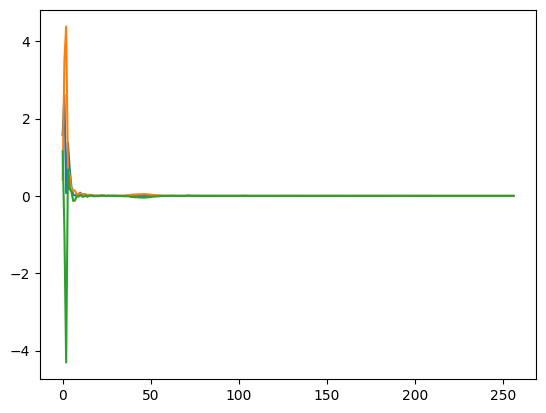

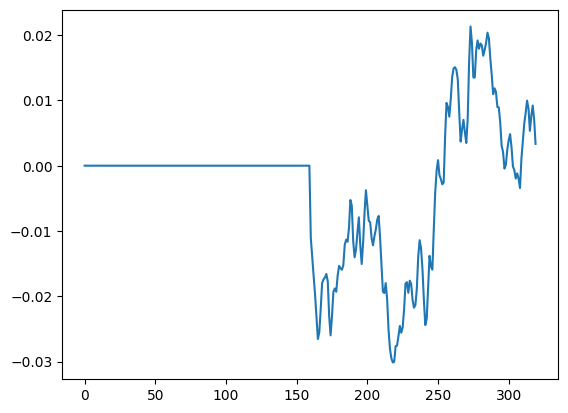

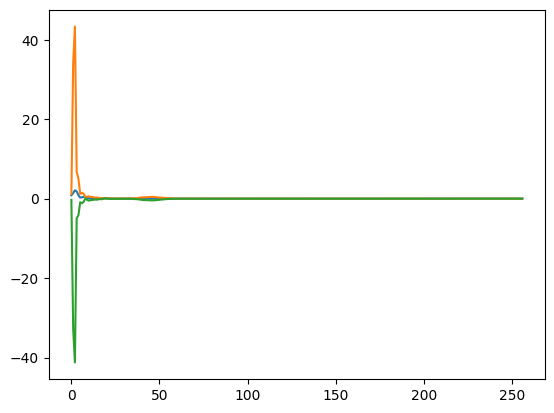

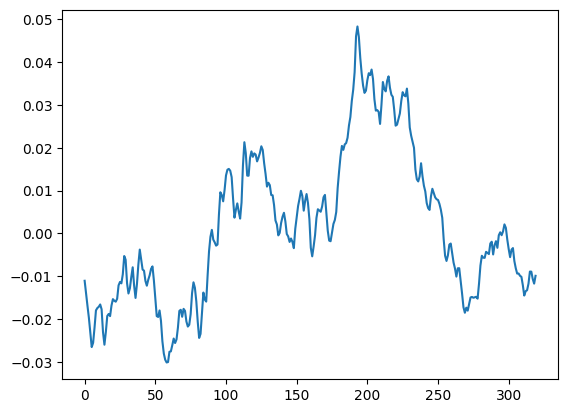

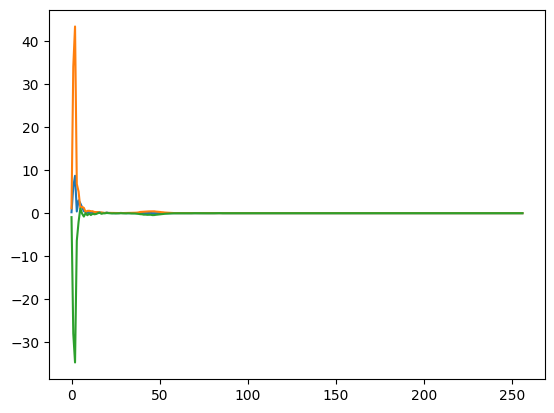

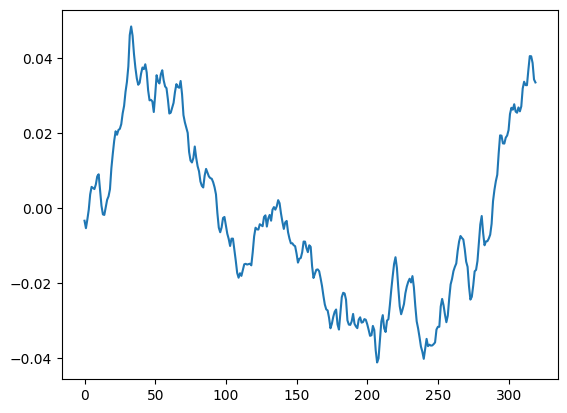

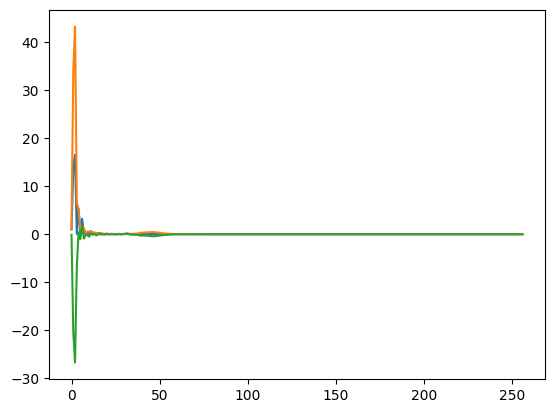

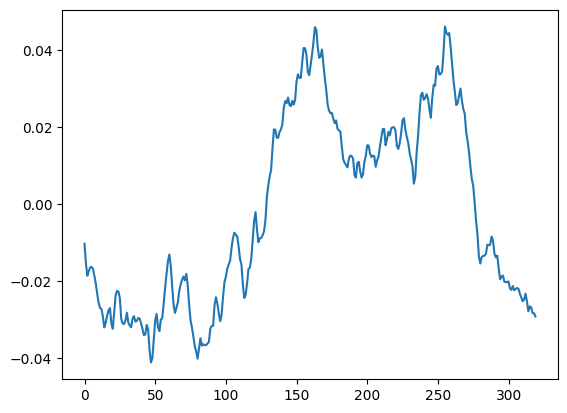

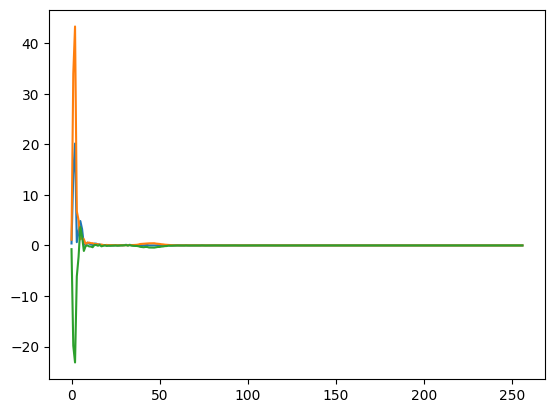

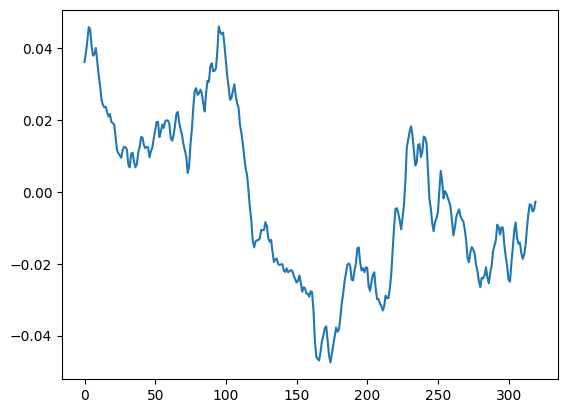

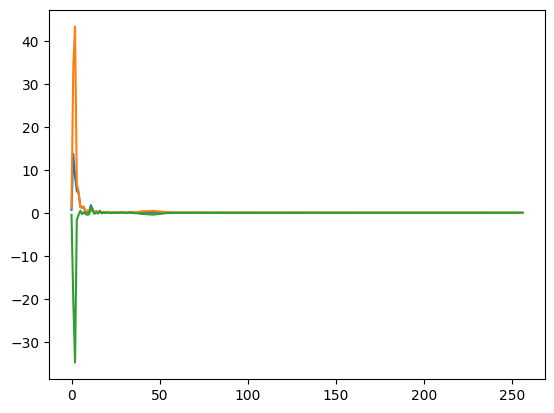

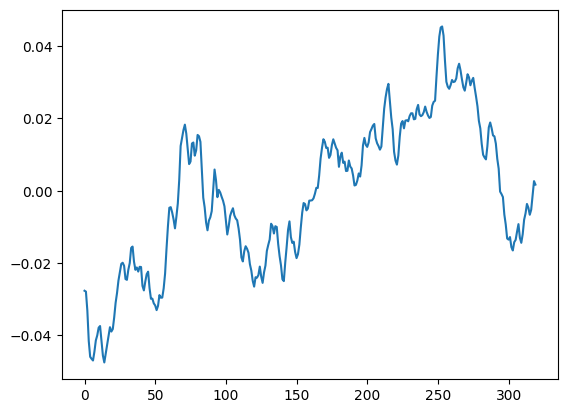

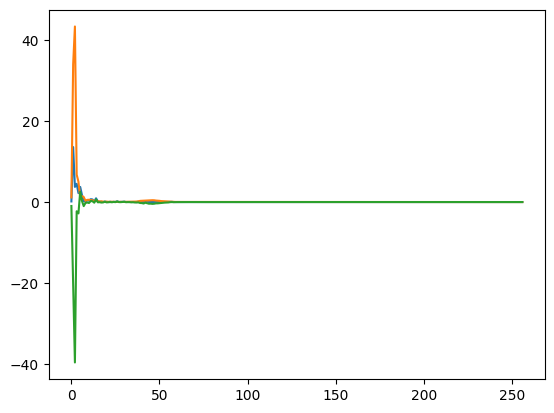

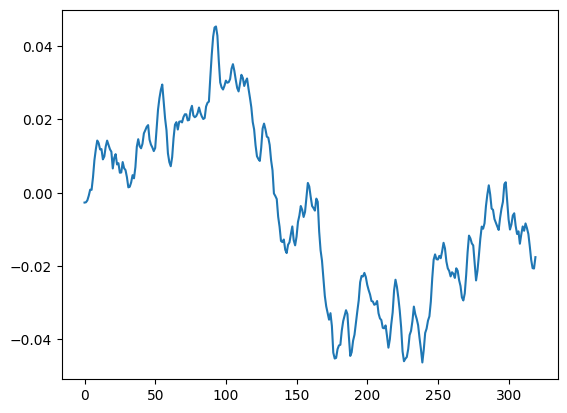

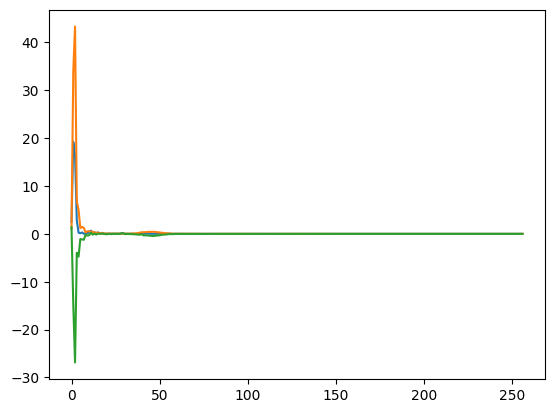

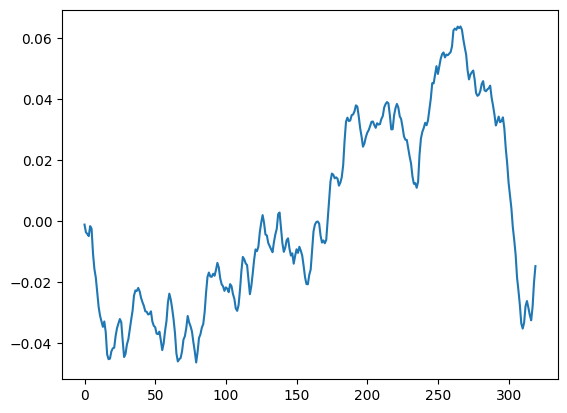

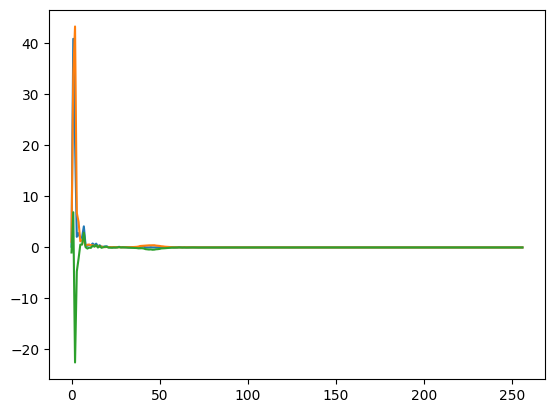

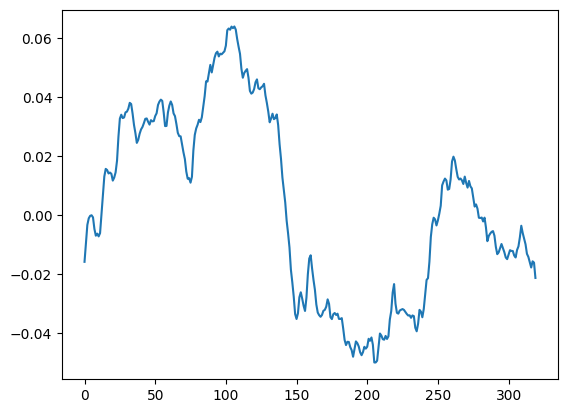

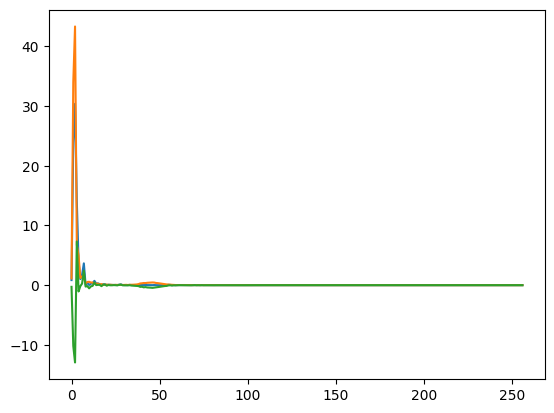

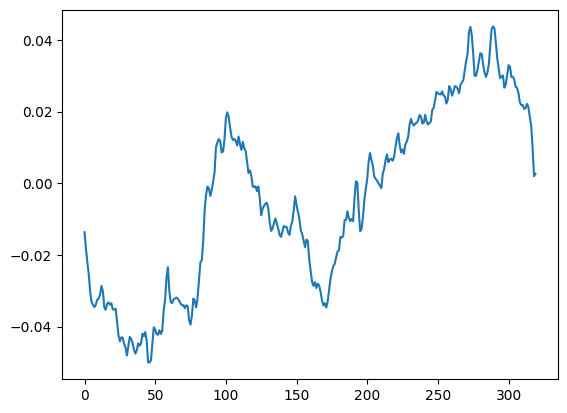

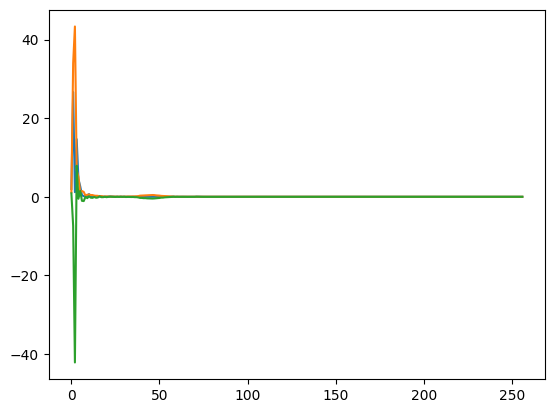

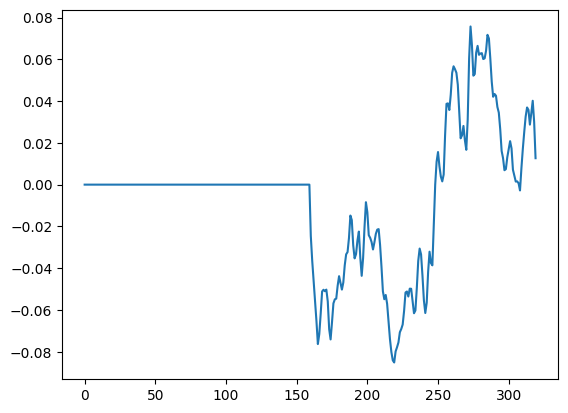

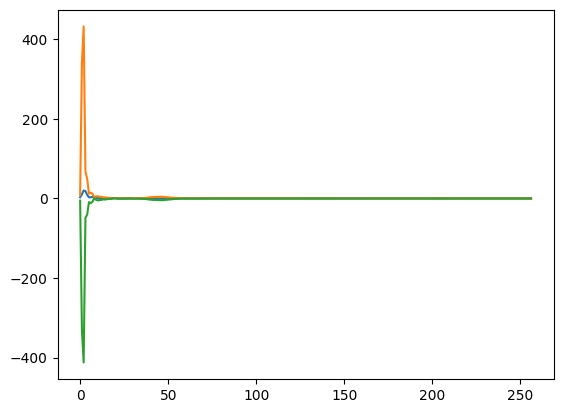

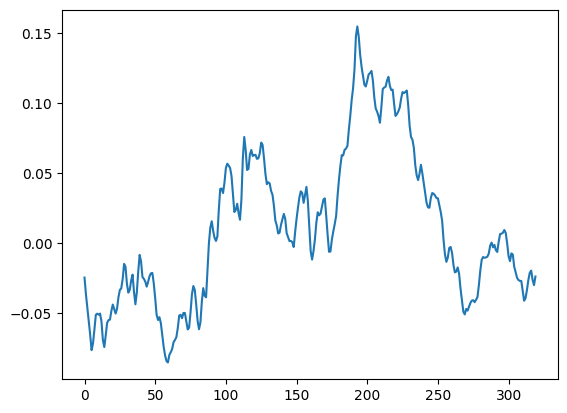

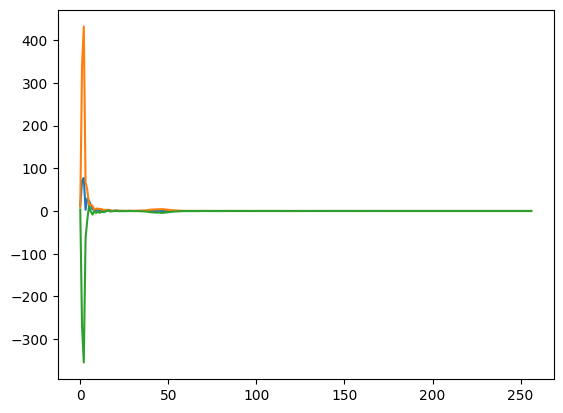

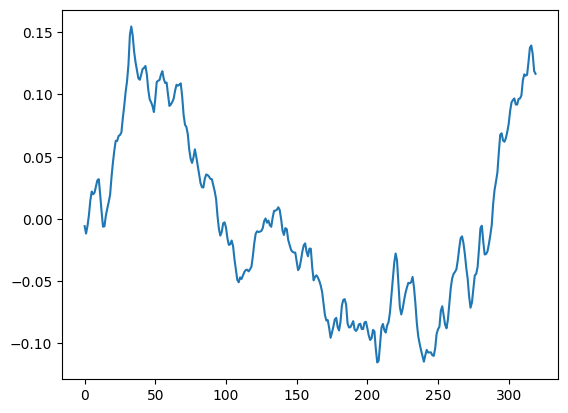

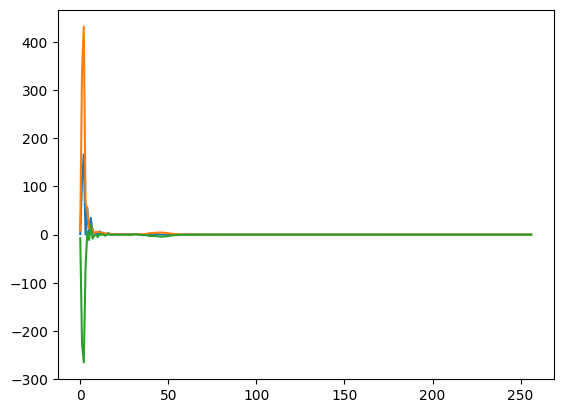

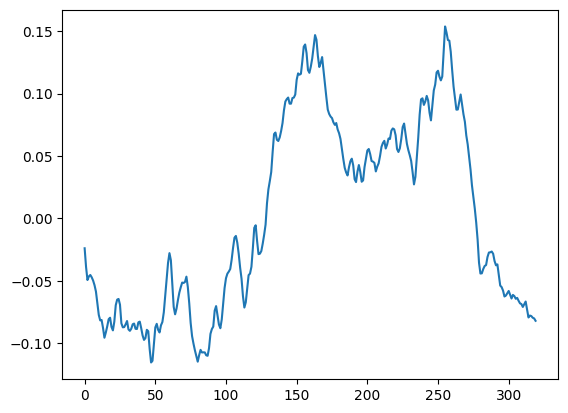

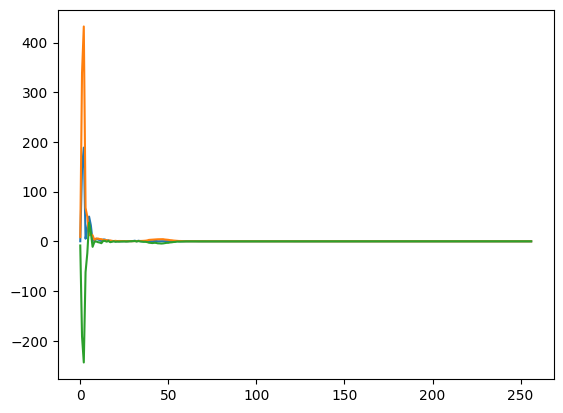

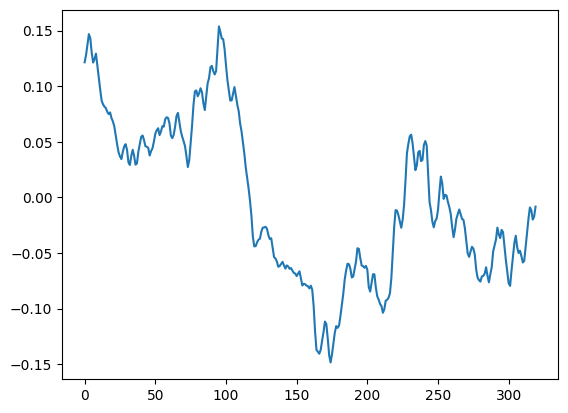

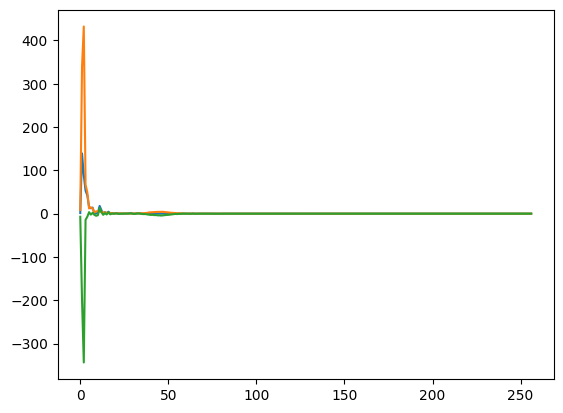

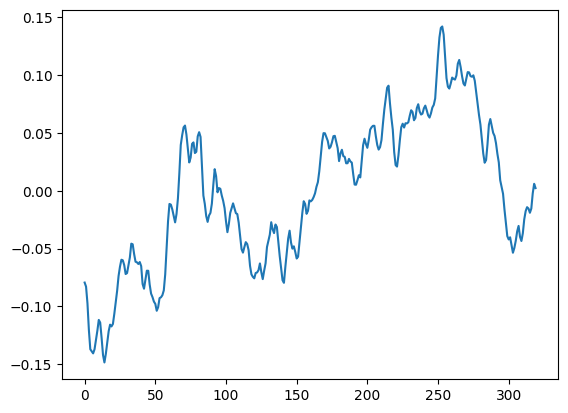

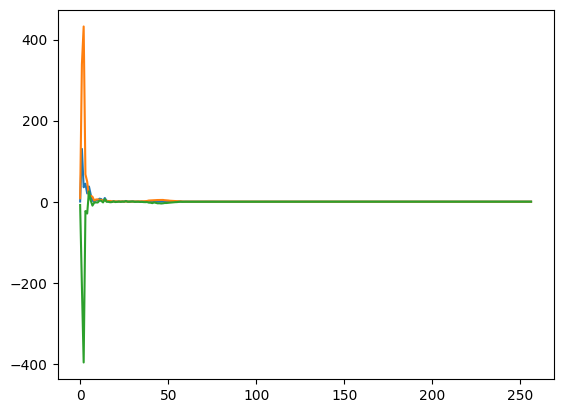

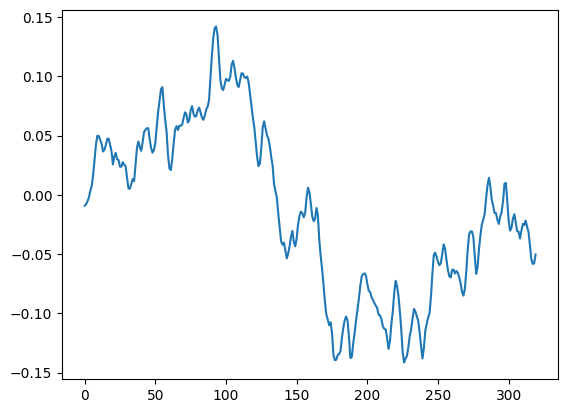

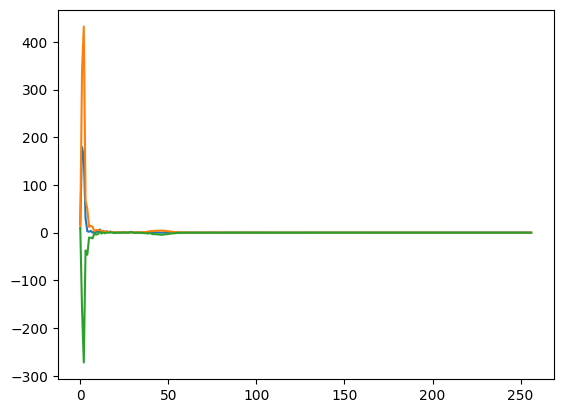

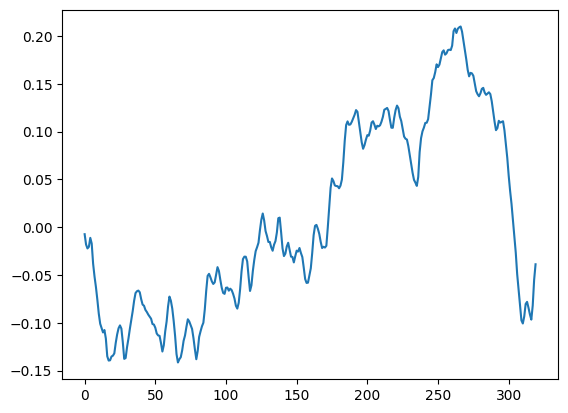

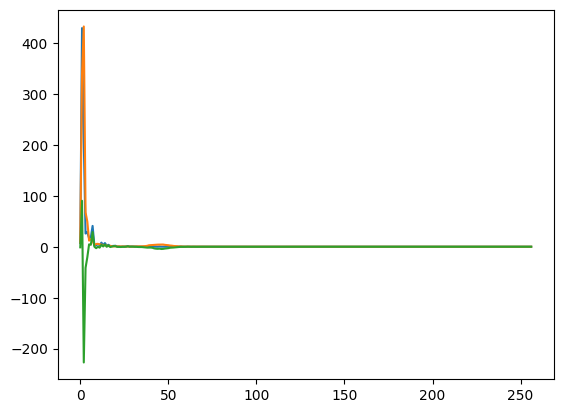

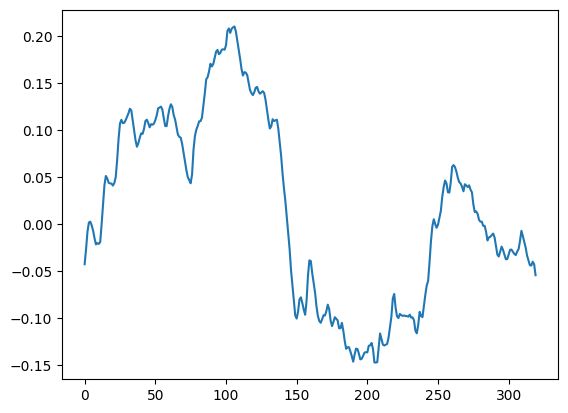

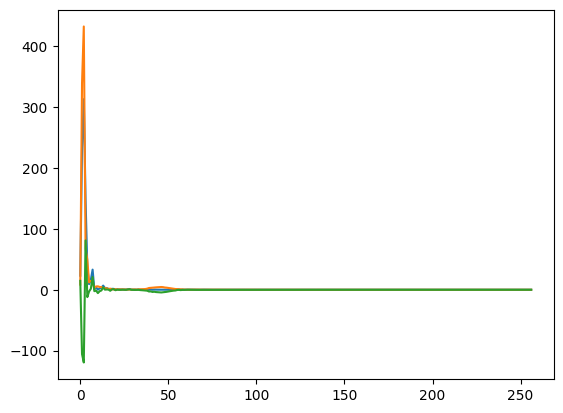

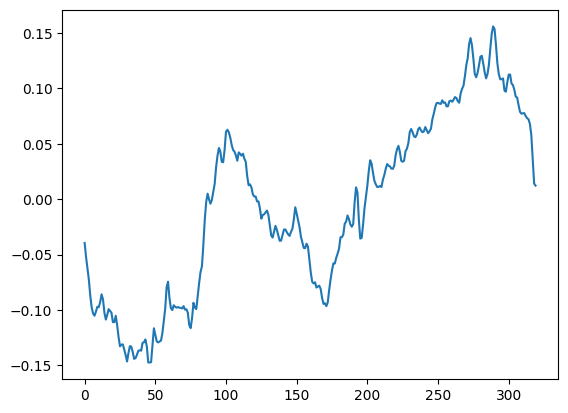

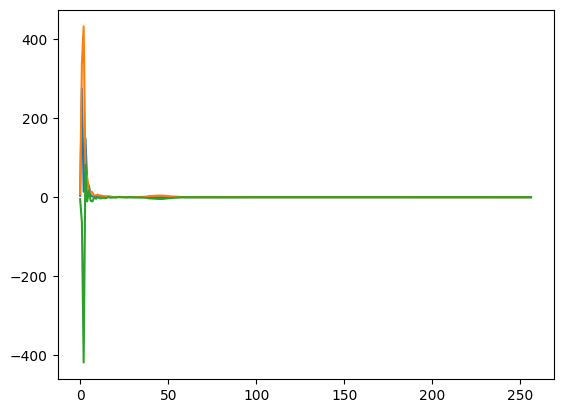

In [25]:
order = 30
noverlap = int(Fs*0.003)   # 3ms

minwfgain = 10**(-13/20)
#minwfgain = 10**(-20/20)

fola = firoverlapadd()
fola.set(Ns=Ns, Nov=noverlap, order=order, FIRshift=order//2)

# overlap add 를 할 때는 10ms 씩 shift 해야 한다.
xbuf = np.zeros(Nf)
speechest = []
for mix in mixedSig:
    Pnn = estSpect(mix, np.array([[0.0, 0.5]])*Fs)
    
    Tx = len(mix)
    yout = np.zeros(Nx+fola.getDelay())
    Lout = 0
    xbuf[:] = 0
    t = 0  # time index
    while True:
        t1 = min(t,Nx)      # 시작 샘플, 마지막 샘플인덱스보다는 작아야 함
        t2 = min(t+Ns,Nx)   # 끝 샘플, 마지막 샘플인덱스보다는 작아야 함
        
        for ii in range(Nf-Ns):
            xbuf[ii] = xbuf[ii+Ns]
        xbuf[(Nf-Ns):] = 0
        for ii in range(t2-t1):
            xbuf[(Nf-Ns)+ii] = mix[t1+ii]
        if t<Ns*10:
            plt.figure()
            plt.plot(xbuf)
        X = np.fft.fft(xbuf, NFFT)
        aX2 = (X*np.conj(X))
        Pxx = aX2[:hNo].real
        Pxx = np.maximum(1e-100, Pxx)  # to prevent divide by zero
        H = (Pxx-Pnn)/Pxx
        H = np.maximum(minwfgain, H)        
        if t<Ns*10:
            plt.figure()
            #plt.plot(H)
            plt.plot(Pxx)
            plt.plot(Pnn)
            plt.plot(Pxx-Pnn)
        h, _ = getLPHFIRFFT(H, order, winname='hamming')
        x = mix[t1:t2]
        y, l = fola.doFilterMem(h,x)
        if l > len(yout)-Lout:
            print(len(yout), Lout, len(yout)-Lout, Lout, l)
            l = len(yout)-Lout            
        if l <= 0: break
        
        yout[Lout:(Lout+l)] = y[:l]
        Lout += l
        t += Ns
        
    speechest.append(yout)

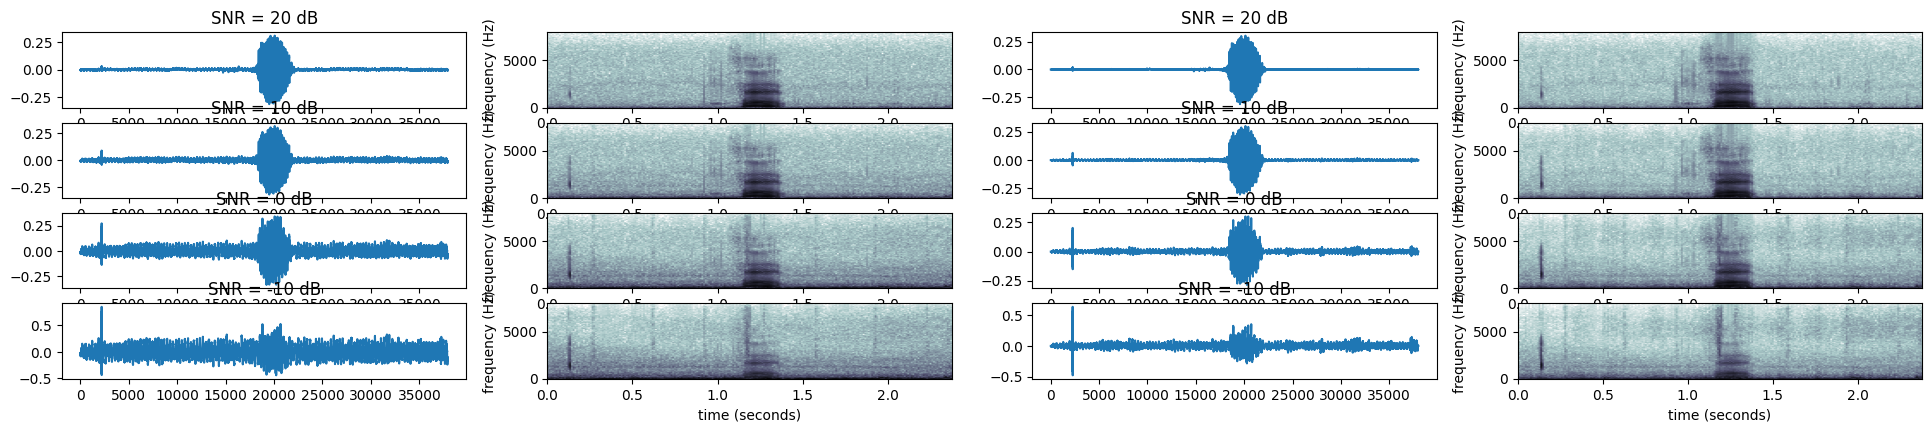

In [26]:
plt.figure(figsize=FIG_SIZE*np.array([3.0,1.5]))

for m in range(len(mixedSig)):
    plt.subplot(len(mixedSig),4,(m+1)*4-3)
    plt.plot(mixedSig[m])
    plt.title('SNR = %.0f dB' % (mixsnrs[m]))
    plt.subplot(len(mixedSig),4,(m+1)*4-2)
    drawspectrogram2(mixedSig[m], Nf, Ns, minpercentile=1, isdbscale=True, isdraw=True)
    plt.subplot(len(mixedSig),4,(m+1)*4-1)
    plt.plot(speechest[m])
    plt.title('SNR = %.0f dB' % (mixsnrs[m]))
    plt.subplot(len(mixedSig),4,(m+1)*4-0)
    drawspectrogram2(speechest[m], Nf, Ns, minpercentile=1, isdbscale=True, isdraw=True)


---
## Programming assignments: spectral subtraction and Wiener filtering, end point detectoin

1. 각각의 SNR에 대해서 잡음을 앞의 0.5 초 구간에서 추정하고 이를 차감하는 FIR 필터를 적용하여 잡음을 제거한다.
2. energy 기반 end point detectoin 을 구현한다. 
3. end point detection 으로 정확하게 구한 잡음 구간에서 잡음 스펙트럼을 추정하고 이를 차감한다.

.

## End of Lab 04